In [1]:
# 모듈 선언
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
import cv2, dlib
import time
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imutils import face_utils
from google.colab.patches import cv2_imshow
from tqdm import tqdm

# CNN 모델 만들기

In [2]:
# dataset
# 출처 : https://github.com/kairess/eye_blink_detector/tree/master/dataset
x_train = np.load('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/dataset/x_train.npy').astype(np.float32)
y_train = np.load('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/dataset/y_train.npy').astype(np.float32)
x_val = np.load('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/dataset/x_val.npy').astype(np.float32)
y_val = np.load('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/dataset/y_val.npy').astype(np.float32)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2586, 26, 34, 1) (2586, 1)
(288, 26, 34, 1) (288, 1)


In [3]:
# Image Augmentation(옵션을 더 많이 줘서 개선)
train_argmentation = ImageDataGenerator(
    rescale=1./255, # 이미지 0-1 사이의 값으로 변경
    rotation_range=10,
    zoom_range=0.2,
    shear_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)

val_argmentation = ImageDataGenerator(
    rescale=1./255
)

augment_size = 50
train_generator = train_argmentation.flow(
    x=x_train, y=y_train,
    batch_size=augment_size,
    shuffle=True
)
val_generator = val_argmentation.flow(
    x=x_val, y=y_val,
    batch_size=augment_size,
    shuffle=False
)

In [4]:
# CNN 모델 생성(tensorflow로 개선)
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(input_shape=(26, 34, 1), kernel_size=(3,3), filters=32, strides=1, padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=64, padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Conv2D(kernel_size=(3,3), filters=128, padding='same', strides=1, activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2)),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 34, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 17, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 17, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 8, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 6, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 4, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


52/52 [==============================] - 33s 23ms/step - loss: 0.5467 - accuracy: 0.7297 - val_loss: 0.3224 - val_accuracy: 0.8750
Epoch 2/25
52/52 [==============================] - 1s 17ms/step - loss: 0.3311 - accuracy: 0.8650 - val_loss: 0.2163 - val_accuracy: 0.9375
Epoch 3/25
52/52 [==============================] - 1s 17ms/step - loss: 0.2439 - accuracy: 0.9091 - val_loss: 0.1583 - val_accuracy: 0.9479
Epoch 4/25
52/52 [==============================] - 1s 17ms/step - loss: 0.1721 - accuracy: 0.9412 - val_loss: 0.0770 - val_accuracy: 0.9722
Epoch 5/25
52/52 [==============================] - 1s 17ms/step - loss: 0.1972 - accuracy: 0.9304 - val_loss: 0.0933 - val_accuracy: 0.9757
Epoch 6/25
52/52 [==============================] - 1s 17ms/step - loss: 0.1223 - accuracy: 0.9575 - val_loss: 0.0538 - val_accuracy: 0.9896
Epoch 7/25
52/52 [==============================] - 1s 17ms/step - loss: 0.1180 - accuracy: 0.9594 - val_loss: 0.0763 - val_accuracy: 0.9722
Epoch 8/25
52/52 [=====

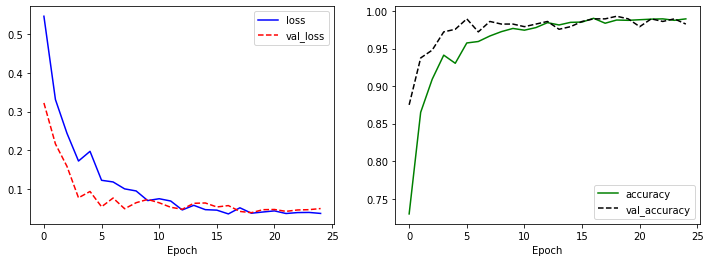

In [5]:
# 모델 학습
history = model.fit_generator(train_generator, epochs=25, validation_data=val_generator)

# 학습 결과 시각화
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'k--', label='val_accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.show()

test acc: 0.9826388888888888


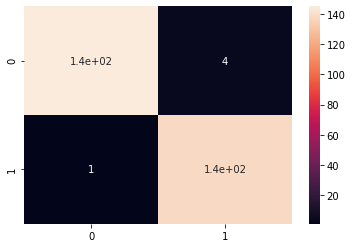

In [6]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

y_pred = model.predict(x_val/255.)
y_pred_logical = (y_pred > 0.5).astype(np.int)

print ('test acc: %s' % accuracy_score(y_val, y_pred_logical))
cm = confusion_matrix(y_val, y_pred_logical)
sns.heatmap(cm, annot=True)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


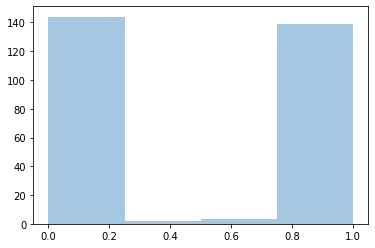

In [7]:
ax = sns.distplot(y_pred, kde=False)

# 감은 눈 검출

In [8]:
# https://github.com/kairess/eye_blink_detector/blob/master/test.py
IMG_SIZE = (34, 26)

# 얼굴 특징점 추출
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/shape_predictor_68_face_landmarks.dat')

In [9]:
def crop_eye(img, eye_points):
    x1, y1 = np.amin(eye_points, axis=0)
    x2, y2 = np.amax(eye_points, axis=0)
    cx, cy = (x1 + x2) / 2, (y1 + y2) / 2

    w = (x2 - x1) * 1.2
    h = w * IMG_SIZE[1] / IMG_SIZE[0]

    margin_x, margin_y = w / 2, h / 2

    min_x, min_y = int(cx - margin_x), int(cy - margin_y)
    max_x, max_y = int(cx + margin_x), int(cy + margin_y)

    eye_rect = np.rint([min_x, min_y, max_x, max_y]).astype(np.int)

    eye_img = gray[eye_rect[1]:eye_rect[3], eye_rect[0]:eye_rect[2]]

    return eye_img, eye_rect

In [10]:
# main(동영상 저장과 경고 알림 추가)
cap = cv2.VideoCapture('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/videos/sleeping_eyes.mp4')
total_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
cnt = 0

for now_frame in tqdm(range(total_frame)):
    ret, img_ori = cap.read()

    if not ret:
        break

    img_ori = cv2.resize(img_ori, dsize=(0, 0), fx=0.5, fy=0.5)

    img = img_ori.copy()
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = detector(gray)

    for face in faces:
        shapes = predictor(gray, face)
        shapes = face_utils.shape_to_np(shapes)

        eye_img_l, eye_rect_l = crop_eye(gray, eye_points=shapes[36:42])
        eye_img_r, eye_rect_r = crop_eye(gray, eye_points=shapes[42:48])

        eye_img_l = cv2.resize(eye_img_l, dsize=IMG_SIZE)
        eye_img_r = cv2.resize(eye_img_r, dsize=IMG_SIZE)
        eye_img_r = cv2.flip(eye_img_r, flipCode=1)

        eye_input_l = eye_img_l.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.
        eye_input_r = eye_img_r.copy().reshape((1, IMG_SIZE[1], IMG_SIZE[0], 1)).astype(np.float32) / 255.

        pred_l = model.predict(eye_input_l)
        pred_r = model.predict(eye_input_r)

        # visualize
        state_l = '%.1f' if pred_l > 0.1 else '%.1f'
        state_r = '%.1f' if pred_r > 0.1 else '%.1f'

        state_l = state_l % pred_l
        state_r = state_r % pred_r

        if state_l == '0.0' and state_r == '0.0':
            cnt += 1
        if cnt > 30:
            cv2.putText(img, "Warning!", (100, 300), cv2.FONT_HERSHEY_PLAIN, 12.0, (0, 0, 255), 5)
        if state_l > '0.3' or state_r > '0.3':
            cnt = 0

        cv2.rectangle(img, pt1=tuple(eye_rect_l[0:2]), pt2=tuple(eye_rect_l[2:4]), color=(255,255,255), thickness=2)
        cv2.rectangle(img, pt1=tuple(eye_rect_r[0:2]), pt2=tuple(eye_rect_r[2:4]), color=(255,255,255), thickness=2)

        cv2.putText(img, state_l, tuple(eye_rect_l[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
        cv2.putText(img, state_r, tuple(eye_rect_r[0:2]), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)

    # 이미지 파일 생성
    cv2.imwrite(f"/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/result/{now_frame:.0f}.jpg", img)

100%|██████████| 214/214 [00:36<00:00,  5.87it/s]


In [11]:
# 참고 : https://hanryang1125.tistory.com/19
import glob

img_array = []

for file in tqdm(glob.glob('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/result/*.jpg')):
    img = cv2.imread(file)
    img_array.append(img)

height, width = img.shape[:2]
size = (width, height)
video = cv2.VideoWriter('/content/drive/MyDrive/Colab Notebooks/ComputerVision/project/result/result.avi',cv2.VideoWriter_fourcc(*'DIVX'), 20, size)

for img in img_array:
    video.write(img)

video.release()

100%|██████████| 214/214 [00:02<00:00, 97.78it/s]


# APPENDIX
### 외부 데이터 출처
    
* http://parnec.nuaa.edu.cn/_upload/tpl/02/db/731/template731/pages/xtan/publication.htm
* https://hanryang1125.tistory.com/19
* https://github.com/kairess/eye_blink_detector